In [2]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.lines import Line2D
from math import radians, sin, cos, asin, sqrt
import re
import requests
import datetime
from statistics import median, quantiles


import geohash2
import pyproj
from pyproj import Proj, transform, CRS
from functools import partial
import geopandas as gpd
from shapely.geometry import Point, Polygon
from geopy.distance import geodesic
from scipy.spatial import cKDTree
from scipy.stats import poisson

from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp
from ortools.linear_solver import pywraplp

import random
from tqdm import tqdm
from time import sleep

# Data Loading

## Loading functions

In [2]:
def calculate_demand(row):
    probabilities = {
        '0-10': 0,
        '10-20': 0.003458068783068975,
        '20-30': 0.013896825396825975,
        '30-40': 0.02136825396825512,
        '40-50': 0.02338333333333506,
        '50-60': 0.026277248677250214,
        '60-70': 0.03332089947090043,
        '70-80': 0.046515343915346036,
        '80+': 0.046515343915346036,
    }

    total_demand = 0
    for age_group, count in row['Alter'].items():
        lambda_value = count * probabilities[age_group]
        total_demand += poisson.rvs(lambda_value)
    return total_demand * 365


def setup_customer_data():
    customers_gdf = gpd.read_file('./WLP/cluster_wuerzburg.gpkg')
    customers_gdf['Alter'] = customers_gdf['Alter'].apply(json.loads)

    customers_gdf['nachfrage'] = customers_gdf.apply(calculate_demand, axis=1)

    bevoelkerung_sum = customers_gdf[customers_gdf['cluster'] != -1].groupby('cluster')['sum_INSGESAMT_0'].sum()
    noise_demand = customers_gdf[customers_gdf['cluster'] == -1]['nachfrage'].iloc[0]

    # Verteilung des Noise-Bedarfs auf die anderen Cluster anteilig zur Anzahl der Polygone
    for cluster in bevoelkerung_sum.index:
        cluster_demand = noise_demand * (bevoelkerung_sum[cluster] / bevoelkerung_sum.sum())
        customers_gdf.loc[customers_gdf['cluster'] == cluster, 'nachfrage'] += np.round(cluster_demand)

    customers_gdf = customers_gdf[customers_gdf['cluster'] != -1].reset_index(drop=True)
    # Set Index to cluster id
    customers_gdf.set_index(['cluster'], inplace=True)

    return customers_gdf


def load_energy_costs():
    # Calculate timestamps (current time minus 48 hours and current time)
    current_time = datetime.datetime.now()
    past_timestamp = (current_time - datetime.timedelta(days=365)).timestamp() * 1000
    current_timestamp = current_time.timestamp() * 1000

    # Construct the API URL with updated timestamps
    api_url = f"https://api.awattar.de/v1/marketdata?start={past_timestamp}&end={current_timestamp}"

    # Send GET request using the requests library
    try:
        response = requests.get(api_url)
        response.raise_for_status()  # Raise an exception for non-2xx status codes
    except requests.exceptions.RequestException as error:
        print(f"Error: {error}")

    # Load data in json format
    data_energy = json.loads(response.content)
    # Extract market prices
    market_prices = [item["marketprice"] for item in data_energy["data"]]

    # Calculate quantiles
    q1, q2, q3 = quantiles(market_prices)  # Use quartiles function
    # Transform to Eur/kWh
    q1_kwh_eur = q1 / 1000
    q2_kwh_eur = q2 / 1000
    q3_kwh_eur = q3 / 1000

    print(f"Median market price (kWh): {q2_kwh_eur:.5f} Eur/kWh")
    print(f"25th percentile (Q1, kWh): {q1_kwh_eur:.2f} Eur/kWh")
    print(f"75th percentile (Q3, kWh): {q3_kwh_eur:.2f} Eur/kWh")

    return data_energy, q1_kwh_eur, q2_kwh_eur, q3_kwh_eur


def calculate_travel_costs(warehouses_gdf, customers_gdf):
    # Create an empty list to store the results
    data = []
    # Iterate through each warehouse in the warehouse DataFrame
    for warehouse_index, warehouse in warehouses_gdf.iterrows():
        for customer_index, customer in customers_gdf.iterrows():
            # Calculate the distance between the centroid of the region and the warehouse
            travel_distance = warehouse.geometry.distance(customer.geometry.centroid)/1000
            # Append the calculated values to the list
            data.append({'warehouse_id': warehouse_index, 'region_id': customer_index, 'travel_distance': travel_distance})
    # Create a DataFrame from the collected data
    df = pd.DataFrame(data)
    return df


def load_data(customers_gdf):
    
    # Grenzen des Simulationsrahmens laden
    geo_bundesländer = gpd.read_file('./GeoDaten/DE_NUTS5000.gpkg')
    geo_würzburg = geo_bundesländer[geo_bundesländer['NUTS_NAME'].str.contains('Würzburg')]
    geo_würzburg = geo_würzburg.to_crs('3035')

    # Detaillierte Gebäude/Personen Daten laden
    bevölkerungs_gdf = gpd.read_file('./WLP/pharmacy_assigned_complete.gpkg')
    bevölkerungs_gdf['Alter'] = bevölkerungs_gdf['Alter'].apply(json.loads)
    bevölkerungs_gdf['Geschlecht'] = bevölkerungs_gdf['Geschlecht'].apply(json.loads)

    # Apotheken Daten laden
    pharmacy_df = pd.read_csv('./OSM_Data/Würzburg-Apotheken.csv')
    pharmacy_gdf = gpd.GeoDataFrame(pharmacy_df, geometry=gpd.points_from_xy(pharmacy_df['lon'], pharmacy_df['lat']), crs=CRS("EPSG:4326"))
    pharmacy_gdf = pharmacy_gdf.to_crs(bevölkerungs_gdf.crs)

    # Warehouse Daten laden
    warehouses_gdf = gpd.read_file('./WLP/warehouses_wuerzburg.gpkg')

    # Distanzmatrix der Cluster und Warehouses erstellen
    shifts_df = calculate_travel_costs(warehouses_gdf, customers_gdf)
    shifts_df.set_index(['warehouse_id', 'region_id'], inplace=True)

    #Loading the energy_data
    data_energy, q1_kwh_eur, q2_kwh_eur, q3_kwh_eur = load_energy_costs()

    return geo_würzburg, bevölkerungs_gdf, pharmacy_gdf, warehouses_gdf, shifts_df, data_energy, q1_kwh_eur, q2_kwh_eur, q3_kwh_eur


## Load the data

In [3]:
customers_gdf = setup_customer_data()
geo_würzburg, bevölkerungs_gdf, pharmacy_gdf, warehouses_gdf, shifts_df, data_energy, q1_kwh_eur, q2_kwh_eur, q3_kwh_eur = load_data(customers_gdf)

Median market price (kWh): 0.08192 Eur/kWh
25th percentile (Q1, kWh): 0.06 Eur/kWh
75th percentile (Q3, kWh): 0.10 Eur/kWh


# Plotting the Data

In [ ]:
# Rahmen der Grafik definieren
fig, ax = plt.subplots(figsize=(6, 6))
geo_würzburg.boundary.plot(ax=ax, color='gray', linewidth=0.5)

# Plotte gdf_loaded auf dieselbe Achse
pharmacy_gdf.plot(ax=ax, markersize=20)

# Titel hinzufügen
plt.title('Apothekenstandorte im Landkreis Würzburg')
plt.axis('off')

# Add scale bar
scalebar = ScaleBar(1, location='lower left', label='Maßstab')
ax.add_artist(scalebar)

# Zeige den Plot an
plt.show()

In [ ]:
# Create a colormap based on the "nachfrage" column
vmin = customers_gdf['nachfrage'].min()
vmax = customers_gdf['nachfrage'].max()
cmap = 'coolwarm'  

# Plot the raster with boundary
ax = geo_würzburg.boundary.plot(color='gray', linewidth=0.5, figsize = (5,5))

# Plot the customers with custom colormap
customers_gdf.plot(ax=ax, column='nachfrage', cmap=cmap, vmin=vmin, vmax=vmax)

# Add title and labels
plt.axis('off')
plt.title('Nachfrage der Cluster des Landkreis Würzburg')
#plt.xlabel('Breitengradkoordinate im CSR3035 Format')
#plt.ylabel('Längengradkoordinate im CSR3035 Format')

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []  # Fake up the array of the scalar mappable
cbar = plt.colorbar(sm, ax=ax, shrink=0.5, label='Nachfrage')  # Adjust shrink value as needed

# Add scale bar
scalebar = ScaleBar(1, location='lower left', label='Maßstab')  # 1 pixel = 1 meter
ax.add_artist(scalebar)

plt.show()

In [ ]:
# Create a colormap based on the "total_price" column
vmin = warehouses_gdf['total_price_big'].min()
vmax = warehouses_gdf['total_price_big'].max()
cmap = 'coolwarm'  


# Rahmen der Grafik definieren
fig, ax = plt.subplots(figsize=(6, 6))
geo_würzburg.boundary.plot(ax=ax, color='gray', linewidth=0.5)

# Plotte gdf_loaded auf dieselbe Achse
warehouses_gdf.plot(ax=ax, column='total_price_big', cmap=cmap, markersize=20)

# Titel hinzufügen
plt.title('Lagerhaltungsimmobilien (Max) des Landkreis Würzburg')
plt.axis('off')

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []  # Fake up the array of the scalar mappable
cbar = plt.colorbar(sm, ax=ax, shrink=0.5, label='Gesamter Mietpreis für ein Jahr')  # Adjust shrink value as needed

# Add scale bar
scalebar = ScaleBar(1, location='lower left', label='Maßstab')
ax.add_artist(scalebar)

# Zeige den Plot an
plt.show()

In [ ]:
# Create a colormap based on the "total_price" column
vmin = warehouses_gdf['total_price_small'].min()
vmax = warehouses_gdf['total_price_small'].max()
cmap = 'coolwarm'  


# Rahmen der Grafik definieren
fig, ax = plt.subplots(figsize=(6, 6))
geo_würzburg.boundary.plot(ax=ax, color='gray', linewidth=0.5)

# Plotte gdf_loaded auf dieselbe Achse
warehouses_gdf.plot(ax=ax, column='total_price_small', cmap=cmap, markersize=20)

# Titel hinzufügen
plt.title('Lagerhaltungsimmobilien (Min) des Landkreis Würzburg')
plt.axis('off')

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []  # Fake up the array of the scalar mappable
cbar = plt.colorbar(sm, ax=ax, shrink=0.5, label='Gesamter Mietpreis für ein Jahr')  # Adjust shrink value as needed

# Add scale bar
scalebar = ScaleBar(1, location='lower left', label='Maßstab')
ax.add_artist(scalebar)

# Zeige den Plot an
plt.show()

In [ ]:
# Convert JSON data to pandas DataFrame
df_energy = pd.DataFrame(data_energy["data"])

# Convert timestamps to datetime format
df_energy["start_timestamp"] = pd.to_datetime(df_energy["start_timestamp"], unit="ms")
df_energy["end_timestamp"] = pd.to_datetime(df_energy["end_timestamp"], unit="ms")

# Filter data for values greater than 0
df_filtered = df_energy[df_energy["marketprice"] > 0]

# Plot market price vs timestamps (using filtered data)
plt.figure(figsize=(12, 6))  # Adjust figure size as needed
plt.plot(df_filtered["start_timestamp"], df_filtered["marketprice"], label="Market Price (Eur/MWh)")

# Set labels and title
plt.xlabel("Date")
plt.ylabel("Market Price (Eur/MWh)")
plt.title("Market Price Fluctuations (Values > 0)")  # Update title

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Set y-axis limits to start from 0 (optional)
plt.ylim(bottom=0)  # This ensures the y-axis starts at 0

# Add gridlines
plt.grid(True)

# Show legend
plt.legend()

plt.tight_layout()
plt.show()

# Optimierungsmodel

## Optimierung

In [ ]:
#Time Window
#Resource Constraint

In [9]:
def optimize(W, R, S, cost_per_km_drone, max_flight_distance, qm_per_customer, factory_setup_costs, minimum_square_requirement):    
    # Create a solver
    solver = pywraplp.Solver('FacilityLocation', pywraplp.Solver.CBC_MIXED_INTEGER_PROGRAMMING)

    # Define decision variables
    x = {}
    for w, r in S:
        x[w,r] = solver.IntVar(0, 1, name=f'x_{w}_{r}')

    y = {}
    for w in W:
        y[w] = solver.IntVar(0, 1, name=f'y_{w}')

    #Objective Function
    objective = solver.Minimize(


    solver.Sum(((y[w] * warehouses_gdf.loc[w, 'total_price_small']) + factory_setup_costs) for w in W) + 

    # Variable costs for transportation
    cost_per_km_drone * 
    solver.Sum([ 
        s/100 * 
        solver.Sum([
            shifts_df.loc[w,r].travel_distance * x[w,r] * customers_gdf.loc[r, 'nachfrage']
            for w, r in S
        ])
        for s in range(90, 111)
    ])
    )

    # Constraints
    # Regions can only be served by open warehouses
    for w in W:
        for r in R:
            constraint = solver.Constraint(-solver.infinity(), 0)
            constraint.SetCoefficient(x[w,r], 1)
            constraint.SetCoefficient(y[w], -1)

    # Each region has to be served by exactly one warehouse
    for r in R:
        constraint = solver.Constraint(1, 1)
        for w in W:
            constraint.SetCoefficient(x[w,r], 1)


    #The distance from warehouse to customer cant be taller than the maximum flight range of each drone
    for w in W:
        for r in R:
            solver.Add(max_flight_distance >= x[w,r] * shifts_df.loc[w,r].travel_distance)


    # Each warehouse has to fulfill a certain minimum space requirement
    for w in W:
        solver.Add(y[w] * minimum_square_requirement <= warehouses_gdf.loc[w, 'floorSpace_small'])


    # Each warehouse needs a certain amount of space for each customer served
    for w in W:
        customer_demand_sum = solver.Sum(x[w, r] * customers_gdf.loc[r, 'sum_INSGESAMT_0'] for r in R)
        solver.Add((customer_demand_sum / 12 * qm_per_customer) <= y[w] * warehouses_gdf.loc[w, 'floorSpace_small'])  # Ensure enough space

    return solver, x, y

## Lösungsausgabe

In [10]:
def solve(W, R, solver, x, y):
  opened_warehouses = []
  customers_gdf['assigned_warehouse'] = 0

  #Solving the problem
  status = solver.Solve()

  def print_solution(status, solver, x, y, W, R):

    if status == pywraplp.Solver.OPTIMAL:
      print("Objective value:", solver.Objective().Value())
      print("Opened warehouses:")
      opened_warehouses.clear()  # Clear the list before appending
      for w in W:
        if y[w].solution_value() > 0.5:
          opened_warehouses.append(w)
          print(f"- Warehouse {w}")
          print(f"Floor-Space: {warehouses_gdf.loc[w, 'floorSpace_small']}")
      print("Warehouse assignments:")
      for r in R:
        assigned_warehouse = None
        for w in W:
          if x[w, r].solution_value() > 0.5:
            assigned_warehouse = w
            break
        if assigned_warehouse:
          customers_gdf.loc[r, 'assigned_warehouse'] = assigned_warehouse
          print(f"- Region {r} served by warehouse {assigned_warehouse}")
          distance = shifts_df.loc[assigned_warehouse, r].travel_distance
          print(f"- Distance: {distance}")
        else:
          print(f"- Region {r} has no assigned warehouse (might be infeasible)")
    else:
      print("Solver failed to find an optimal solution. Status:", status)


  print_solution(status, solver, x, y, W, R)
  
  return opened_warehouses

## Solution Graphics

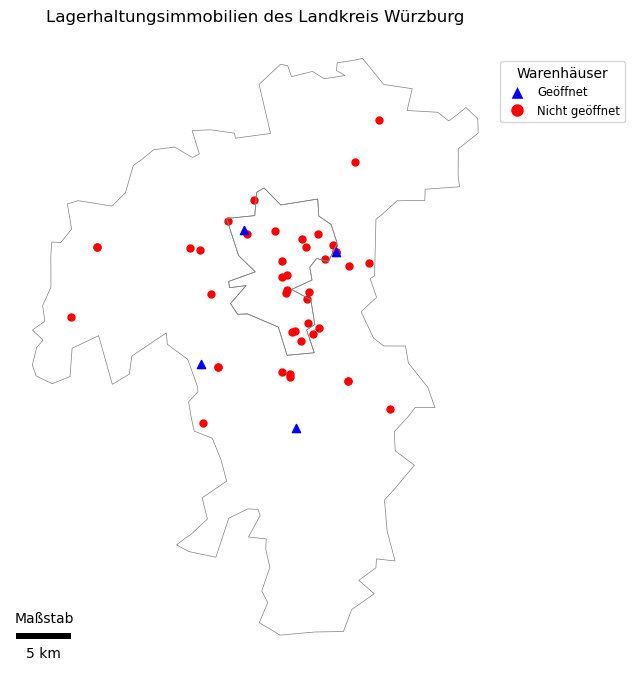

In [18]:
#Rahmen der Grafik definieren
ax = geo_würzburg.boundary.plot(color='gray', linewidth=0.5, figsize = (7,7))

# Plotte gdf_loaded auf dieselbe Achse
warehouses_gdf[~warehouses_gdf.index.isin(opened_warehouses)].plot(ax=ax, color='red', marker='o', markersize=25)
warehouses_gdf.loc[opened_warehouses].plot(ax=ax, color='blue', marker='^', markersize=35)

# Titel hinzufügen
plt.title('Lagerhaltungsimmobilien des Landkreis Würzburg')

plt.axis('off')

# Add scale bar
scalebar = ScaleBar(1, location='lower left', label='Maßstab')
ax.add_artist(scalebar)

# Add legend
custom_legend = [Line2D([0], [0], marker='^', color='w', markerfacecolor='blue', markersize=10, label='Geöffnet'),
                 Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Nicht geöffnet')]
plt.legend(handles=custom_legend, title='Warenhäuser', bbox_to_anchor=(1,0.95), loc='upper left', borderaxespad=0., fontsize='small', ncol=1)
plt.tight_layout()

# # Index jedes Warehouses anzeigen
# for idx, row in warehouses_gdf.loc[opened_warehouses].iterrows():
#     plt.annotate(idx, (row.geometry.x, row.geometry.y), xytext=(5, 5), textcoords='offset points', fontsize=8, color='black')

# for idx, row in warehouses_gdf[~warehouses_gdf.index.isin(opened_warehouses)].iterrows():
#     plt.annotate(idx, (row.geometry.x, row.geometry.y), xytext=(5, 5), textcoords='offset points', fontsize=8, color='black')

# Zeige den Plot an
plt.show()

In [ ]:
# Create a colormap with a color for each opened warehouse
colors = plt.cm.tab20(np.linspace(0, 1, len(opened_warehouses)))
warehouse_colors = dict(zip(opened_warehouses, colors))

# Create a dictionary to map each warehouse to a color
warehouse_colors = {
    warehouse: color
    for warehouse, color in zip(opened_warehouses, warehouse_colors.values())
}

# Plot the boundaries of the region
ax = geo_würzburg.boundary.plot(color='gray', linewidth=0.5, figsize=(8, 8))


# Plot the customers with the color of their assigned warehouse
for index, row in customers_gdf.iterrows():
    warehouse = row['assigned_warehouse']
    color = warehouse_colors.get(warehouse, 'gray')  # Use gray color if warehouse is not in the dictionary
    customers_gdf.iloc[[index]].plot(ax=ax, color=color, markersize=20)


# Plot the warehouses with their assigned colors
for warehouse, color in warehouse_colors.items():
    warehouses_gdf[warehouses_gdf.index == warehouse].plot(ax=ax, color=color, marker='^', markersize=50, edgecolor='black')


# Turn off axis
plt.axis('off')

# Add title
plt.title('Lagerhaltungsimmobilien des Landkreis Würzburg')

# Add legend
legend_handles = [Line2D([0], [0], marker='^', color='w', markerfacecolor=color, markersize=10, label=warehouse) for warehouse, color in warehouse_colors.items()]
ax.legend(handles=legend_handles, title='Warenhäuser', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize='small', ncol=2)

# Add scale bar
scalebar = ScaleBar(1, location='lower left', label='Maßstab')
ax.add_artist(scalebar)

# Show the plot
plt.show()

## Assigning a warehouse to each building based on the optimal value

In [ ]:
# Funktion, um das zugewiesene Lager für einen Punkt zu finden
def find_assigned_warehouse(point, bevölkerungs_gdf_sim):
    
    # Räumlichen Index für das Cluster-GDF erstellen
    cluster_sindex = customers_gdf.sindex

    possible_matches_index = list(cluster_sindex.intersection(point.bounds))
    possible_matches = customers_gdf.iloc[possible_matches_index]
    output = possible_matches[possible_matches.geometry.contains(point)]
    if not output.empty:
        return [output.assigned_warehouse.iloc[0]]
    else:
        nearest_polygon_index = cluster_sindex.nearest(point)[0]
        nearest_polygon = customers_gdf.iloc[nearest_polygon_index]
        return [nearest_polygon.assigned_warehouse.iloc[0]]

In [ ]:
def assign_warehouses(bevölkerungs_gdf_sim):
    # Verfolgen Sie den Fortschritt der apply-Methode
    tqdm.pandas()

    # Die apply-Methode auf die GeoDataFrame anwenden, um das zugewiesene Lager für jeden Punkt zu finden
    warehouses = bevölkerungs_gdf['geometry'].progress_apply(find_assigned_warehouse)

    bevölkerungs_gdf['assigned_warehouse'] = 0
    bevölkerungs_gdf['distance_warehouse'] = 0

    for index, row in tqdm(bevölkerungs_gdf.iterrows(), total=len(bevölkerungs_gdf)):
        bevölkerungs_gdf.loc[index, 'assigned_warehouse'] = warehouses[index][0]
        warehouse_geometry = warehouses_gdf.loc[row['assigned_warehouse']]['geometry']
        population_geometry = row['geometry']
        bevölkerungs_gdf.loc[index, 'distance_warehouse'] = warehouse_geometry.distance(population_geometry) / 1000

## Simulations Loop

In [ ]:
def calculate_demand(row, days, probabilities):
    total_demand = 0
    for age_group, count in row['Alter'].items():
        lambda_value = count * probabilities[age_group]
        total_demand += poisson.rvs(lambda_value)
    return total_demand * days

In [ ]:
def simulate(opened_warehouses, cost_per_km_drone, cost_per_km_car, bevölkerungs_gdf_sim):

    # Wahrscheinlichkeitsverteilung
    probabilities = {
        '0-10': 0.01,
        '10-20': 0.02,
        '20-30': 0.03,
        '30-40': 0.04,
        '40-50': 0.07,
        '50-60': 0.09,
        '60-70': 0.1,
        '70-80': 0.15,
        '80+': 0.2
    }
    
    month_days = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]  # Days in each month (ignoring leap years)
    drone_transportation_cost = 0
    car_transportation_cost = 0
    car_transportation_time = 0
    factory_cost = warehouses_gdf.loc[opened_warehouses].total_price_small.sum()


    #Loop der Simulation über ein gesamtes Jahr
    for i in range(12):

        print(f'Simulation - Monat: {i + 1}')
        
        tqdm.pandas()
        bevölkerungs_gdf_sim['nachfrage'] = 0
        bevölkerungs_gdf_sim['nachfrage'] = bevölkerungs_gdf_sim.progress_apply(calculate_demand, axis=1, days = month_days[i], probabilities = probabilities)

        # Calculate transportation costs and time using vectorized operations
        drone_transportation_cost += np.sum(bevölkerungs_gdf_sim['nachfrage'] * bevölkerungs_gdf_sim['distance_warehouse'] * cost_per_km_drone)
        car_transportation_cost += np.sum(bevölkerungs_gdf_sim['nachfrage'] * bevölkerungs_gdf_sim['distance_pharmacy'] * cost_per_km_car)
        car_transportation_time += np.sum(bevölkerungs_gdf_sim['nachfrage'] * bevölkerungs_gdf_sim['time_pharmacy'])

    return drone_transportation_cost, factory_cost, car_transportation_cost, car_transportation_time

In [ ]:
def print_cost_summary(drone_cost, car_cost, car_time, factory_cost):

  print("-" * 50)
  print("Logistical Cost Summary (per year):")
  print("-" * 50)
  print(f"Drone Transportation Cost: \t€{drone_cost:.2f}")
  print(f"Factory Cost: \t\t\t€{factory_cost:.2f}")
  print("-" * 50)
  print(f"Car/Truck Transportation Cost: \t€{car_cost:.2f}")
  print(f"Car/Truck Transportation Time: \t{car_time/ 60:.2f} hours")
  print("-" * 50)
  print(f"Total Cost Drone: \t\t€{(drone_cost + factory_cost):.2f}")
  print(f"Total Cost Car: \t\t€{(car_cost):.2f}")
  print("-" * 50)

# Robustheit / Parameter Changes

## First optimal run

In [ ]:
base_cost_per_km_drone = 0.01 #Eur

base_flight_distance = 20

base_qm_per_customer = 0.05 #Quadratmeter

base_factory_setup_costs = 5000 #Eur

base_minimum_square_requirement = 50 #Quadratmeter

# battery_capacity = 1000 * 3600 #Watt Stunden * 3600 = Joul
# Epm =  battery_capacity/(max_flight_distance * 1000)
# kWh_km = Epm / 3600000
# cost_per_km_drone = q2_kwh_eur * kWh_km


# Car/Truck Parameters:
cost_per_km_car = 0.38


W = warehouses_gdf.index.values
R = customers_gdf.index.values
S = shifts_df.index.values
bevölkerungs_gdf_original = bevölkerungs_gdf

original_result = []

# Set the optimization problem
solver, x, y = optimize(W, R, S, base_cost_per_km_drone, base_flight_distance, base_qm_per_customer, base_factory_setup_costs, base_minimum_square_requirement)
print('Solver set up!')

# Solve the problem and get the solution
original_opened_warehouses = solve(W, R, solver, x, y)

# Assign the in the solution chosen warehouses in the dataset
assign_warehouses(bevölkerungs_gdf_original)
print('Dataset set up!')

# Simulate with optimal values
drone_transportation_cost, factory_cost, car_transportation_cost, car_transportation_time = simulate(original_opened_warehouses, base_cost_per_km_drone, cost_per_km_car, bevölkerungs_gdf_original)
print('Simulation done!')

# Call the function after calculating the costs
print_cost_summary(drone_transportation_cost, car_transportation_cost, car_transportation_time, factory_cost)

original_result.append({
    'cost_per_km_drone': base_cost_per_km_drone,
    'max_flight_distance_var': base_flight_distance,
    'qm_per_customer_var': base_qm_per_customer,
    'drone_transportation_cost': drone_transportation_cost,
    'factory_cost': factory_cost,
    'car_transportation_cost': car_transportation_cost,
    'car_transportation_time': car_transportation_time,
    'opened_warehouses': original_opened_warehouses,
    'objective_value': solver.Objective().Value()
})

## Second robust testing

In [13]:
def find_min_travel_distance(shifts_df):
    # Initialize variables
    min_distance = 0
    max_distance = shifts_df['travel_distance'].max()
    shifts_df.reset_index(inplace=True)

    while min_distance <= max_distance:

        current_distance = min_distance + 0.1

        # Assuming 'node_a' and 'node_b' are columns containing node IDs, and 'distance' is the distance column
        filtered_data = shifts_df[shifts_df['travel_distance'] < current_distance]

        all_regions = shifts_df.region_id.unique()
        filtered_regions = filtered_data.region_id.unique()  
        region_present = set(all_regions).issubset(set(filtered_regions))

        if region_present:
            break
        else:
            min_distance = current_distance  # Update min distance if condition not met

    shifts_df.set_index(['warehouse_id', 'region_id'], inplace=True)
    return min_distance  # Minimum distance found

In [ ]:
def generate_triangular_value(base_value, variation_pct):

  # Calculate the left and right bounds based on variation percentage
  left_bound = base_value * (1 - variation_pct / 100)
  right_bound = base_value * (1 + variation_pct / 100)

  # Generate a value using random.triangular with calculated bounds and base value as mode
  triangular_value = np.random.triangular(left_bound, base_value, right_bound, 100000)
  return triangular_value

In [ ]:
min_cost_per_km_drone = 0
base_cost_per_km_drone = 0.01 #Eur
max_cost_per_km_drone = 0

min_flight_distance = find_min_travel_distance(shifts_df)
base_flight_distance = 20
max_flight_distance = 30 #Kilometer

min_qm_per_customer = 0
base_qm_per_customer = 0.05 #Quadratmeter
max_qm_per_customer = 0

min_minimum_square_requirement = 0
base_minimum_square_requirement = 50 #Quadratmeter
max_minimum_square_requirement = 0

min_factory_setup_costs = 0
base_factory_setup_costs = 5000 #Eur
max_factory_setup_costs = 0


# battery_capacity = 1000 * 3600 #Watt Stunden * 3600 = Joul
# Epm =  battery_capacity/(max_flight_distance * 1000)
# kWh_km = Epm / 3600000
#cost_per_km_drone = q2_kwh_eur * kWh_km

# Car/Truck Parameters:
cost_per_km_car = 0.38


number_of_variations = 10
W = warehouses_gdf.index.values
R = customers_gdf.index.values
S = shifts_df.index.values
bevölkerungs_gdf_variant = bevölkerungs_gdf

results = []

for i in range(number_of_variations):
    # Original Warehouses
    print(f'Run: {i}, Simulation with original warehouses')
    # Simulate with optimal values
    orig_drone_transportation_cost, orig_factory_cost, orig_car_transportation_cost, orig_car_transportation_time = simulate(original_opened_warehouses, base_cost_per_km_drone, cost_per_km_car, bevölkerungs_gdf_original)
    print('Simulation done!')

    # Call the function after calculating the costs
    print_cost_summary(orig_drone_transportation_cost, orig_car_transportation_cost, orig_car_transportation_time, orig_factory_cost)

    # Variant Warehouses
    print(f'Run: {i}, Simulation with new set warehouses')
    # Set new variant variables
    var_cost_per_km_drone = 0
    var__flight_distance = 0
    var_qm_per_customer = 0
    var_factory_setup_costs = 0
    var_minimum_square_requirement = 0


    # Set the optimization problem
    var_solver, x, y = optimize(W, R, S, var_cost_per_km_drone, var__flight_distance, var_qm_per_customer, var_factory_setup_costs, var_minimum_square_requirement)
    print('Solver set up!')

    # Solve the problem and get the solution
    var_opened_warehouses = solve(W, R, var_solver, x, y)

    # Assign the in the solution chosen warehouses in the dataset
    assign_warehouses(bevölkerungs_gdf_variant)
    print('Dataset set up!')

    # Simulate with optimal values
    var_drone_transportation_cost, var_factory_cost, var_car_transportation_cost, var_car_transportation_time = simulate(var_opened_warehouses, var_cost_per_km_drone, cost_per_km_car, bevölkerungs_gdf_variant)
    print('Simulation done!')

    # Call the function after calculating the costs
    print_cost_summary(var_drone_transportation_cost, var_car_transportation_cost, var_car_transportation_time, var_factory_cost)

    results.append({
        # Original Values
        'drone_transportation_cost_orig': drone_transportation_cost,
        'factory_cost_orig': factory_cost,
        'car_transportation_cost_orig': car_transportation_cost,
        'car_transportation_time_orig': car_transportation_time,

        # New Values
        'cost_per_km_drone_var': var_cost_per_km_drone,
        'flight_distance_var': var__flight_distance,
        'qm_per_customer_var': var_qm_per_customer,
        'drone_transportation_cost_var': var_drone_transportation_cost,
        'factory_cost_var': var_factory_cost,
        'car_transportation_cost_var': var_car_transportation_cost,
        'car_transportation_time_var': var_car_transportation_time,
        'opened_warehouses_var': var_opened_warehouses,
        'objective_value_var': var_solver.Objective().Value()
    })

# Tests

In [ ]:
cost_per_km_drone = 0.01 #Eur
max_flight_distance = 25 #Kilometer
qm_per_customer = 0.05 #Quadratmeter
cost_per_km_drone_var = generate_triangular_value(cost_per_km_drone, 20)
max_flight_distance_var = generate_triangular_value(max_flight_distance, 20)
qm_per_customer_var = generate_triangular_value(qm_per_customer, 20)

In [ ]:
print(cost_per_km_drone_var, max_flight_distance_var, qm_per_customer_var)

In [ ]:
h = plt.hist(generate_triangular_value(cost_per_km_drone, 10), bins=200,
             density=True)
plt.show()

In [17]:
#cost_per_km_drone = 0.01 #Eur
max_flight_distance = find_min_travel_distance(shifts_df) + 0.5 #Kilometer
qm_per_customer = 0.05 #Quadratmeter
minimum_square_requirement = 50 #Quadratmeter
factory_setup_costs = 10000 #Eur

battery_capacity = 1000 * 3600 #Watt Stunden * 3600 = Joul
Epm =  battery_capacity/(max_flight_distance * 1000)
kWh_km = Epm / 3600000
cost_per_km_drone = q2_kwh_eur * kWh_km

# Car/Truck Parameters:
cost_per_km_car = 0.38


W = warehouses_gdf.index.values
R = customers_gdf.index.values
S = shifts_df.index.values

M = 1000000

# Set the optimization problem
solver, x, y = optimize(W, R, S, cost_per_km_drone, max_flight_distance, qm_per_customer, factory_setup_costs, minimum_square_requirement)
print('Solver set up!')

# Solve the problem and get the solution
opened_warehouses = solve(W, R, solver, x, y)


Solver set up!
Objective value: 946579.3785818232
Opened warehouses:
- Warehouse 10
Floor-Space: 250.0
- Warehouse 20
Floor-Space: 64.0
- Warehouse 24
Floor-Space: 6993.0
- Warehouse 31
Floor-Space: 150.0
Warehouse assignments:
- Region 0 served by warehouse 24
- Distance: 17.84429442082577
- Region 1 served by warehouse 24
- Distance: 17.979564174454797
- Region 2 served by warehouse 24
- Distance: 18.357041854156833
- Region 3 served by warehouse 24
- Distance: 15.563803312841719
- Region 4 served by warehouse 24
- Distance: 15.5773230935511
- Region 5 served by warehouse 24
- Distance: 16.292110980346994
- Region 6 served by warehouse 24
- Distance: 15.046008715803382
- Region 7 served by warehouse 24
- Distance: 14.22541860904253
- Region 8 served by warehouse 24
- Distance: 13.6505223711568
- Region 9 served by warehouse 24
- Distance: 14.260728615286569
- Region 10 served by warehouse 24
- Distance: 11.98207316901519
- Region 11 served by warehouse 24
- Distance: 12.9339971811012

In [15]:
max_flight_distance

18.29999999999999